# RNN for text classification and text generation
### Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_rnn_text_classification_generation.ipynb)

In the first part of this exercise, we’ll continue our attempts to classify text using different network architectures. This time, we’ll try a LSTM. We'll use the Metrolyrics dataset we used in the previous exercise.  

You are encouraged to review the code in [this](https://github.com/prakashpandey9/Text-Classification-Pytorch) repo, that contains implementation of several deep learning architectures for text classification in PyTorch. If you face time limitations, you're welcome to adapt it to your needs instead of writing your own code from scratch.

In the second part of this exercise, you'll unleash the hidden creativity of your computer, by letting it generate Country songs (yeehaw!). You'll train a character-level RNN-based language model, and use it to generate new songs.


### Special Note
Our Deep Learning course was packed with both theory and practice. In a short time, you've got to learn the basics of deep learning theory and get hands-on experience training and using pretrained DL networks, while learning PyTorch.  
Past exercises required a lot of work, and hopefully gave you a sense of the challenges and difficulties one faces when using deep learning in the real world. While the investment you've made in the course so far is enormous, I strongly encourage you to take a stab at this exercise. 

DL networks for NLP are much shallower than those for image classification. It's possible to construct your own networks from scratch, and achieve nice results. While I hope the theoretical foundations of RNNs are clear after our class sessions, getting your hands dirty with their implementation in PyTorch allows you to set breakpoints, watch the dimensions of the different layers and components and get a much better understand of theory, in addition to code that might prove useful later for your own projects. 

I tried to provide references for all parts that walk you through a very similar task (actually, the same task on a different dataset). I expect this exercise to require much less of your time than previous exercises.

The exercise is aimed to help you get better understanding of the concepts. I am not looking for the optimal model performance, and don't look for extensive optimization of hyperparameters. The task we face in this exercise, namely the classification of the song’s genre from its text alone, is quite challenging, and we probably shouldn’t expect great results from our classifier. Don’t let this discourage you - not every task reaches an f1 score of 90%+. 

In fact, some of the reasons I chose this dataset is because it highlights some of the issues we face in machine learning models in the real world. Examples include:
- The classes are highly imbalanced - try to think how this affects the network learning
- Given the small amount of data for some classes, you might actually prefer to remove them from the dataset. How would you decide that?
- NLP tasks often involve preprocessing (lowercasing, tokenization, lemmatization, stopwords removal etc.). The decision on the actual preprocessing pipeline depends on the task, and is often influenced by our believes about the data and exploratory analysis of it. Thinking conciously about these questions helps you be a better data scientist
- Some songs contain no lyrics (for example, they just contain the text "instrumental"). Others include non-English characters. You'll often need to preprocess your data and make decisions as to what your network should actually get as input (think - how should you treat newline characters?)
- While model performance on this dataset are not amazing, we can try to answer interesting follow-up questions - which genres are more similar to each other and are often confused? Do genres become more similar through the years? ...

More issues will probably pop up while you're working on this task. If you face technical difficulties or find a step in the process that takes too long, please let me know. It would also be great if you share with the class code you wrote that speeds up some of the work (for example, a data loader class, a parsed dataset etc.)

## RNN for Text Classification
In this section you'll write a text classifier using LSTM, to determine the genre of a song based on its lyrics.  
The code needed for this section should be very similar to code you've written for the previous exercise, and use the same dataset.  

In [1]:
import numpy as np 
import torch
import torch.utils.data as utils_data
from torch.autograd import Variable
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas  as pd
import nltk
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import string 
from livelossplot import PlotLosses
from gensim.models import Word2Vec
import numpy as np 
from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
import torch
import nltk
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import nltk
from nltk.tokenize import RegexpTokenizer
import string 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import unidecode

In [2]:
%matplotlib inline
sns.set_style("darkgrid")
nltk.download('punkt')
nltk.download('stopwords')
use_cuda = torch.cuda.is_available()
all_characters = string.ascii_letters + " .,;'-"
n_characters = len(all_characters) +1
SEED = 999
import random 
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabiburabia24/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabiburabia24/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
!kaggle datasets download -d gyani95/380000-lyrics-from-metrolyrics
!unzip -q 380000-lyrics-from-metrolyrics.zip -d data

In [3]:
!ls data/

ls: cannot access 'data/': No such file or directory


In [3]:
lyrics_df = pd.read_csv("../data/lyrics.csv", usecols=['genre', 'lyrics'])

In [4]:
lyrics_df.describe(include = 'all')

,genre,lyrics
count,362237,266557
unique,12,244873
top,Rock,INSTRUMENTAL
freq,131377,1369


In [5]:
lyrics_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 2 columns):
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )


In [8]:
lyrics_df = lyrics_df[lyrics_df.lyrics.notnull()]
import unicodedata

#lyrics_df["ascii_lyrics"] = lyrics_df["lyrics"].map(lambda text:  unidecode.unidecode(text))
lyrics_df["ascii_lyrics"] = lyrics_df["lyrics"].map(lambda text:  unicodeToAscii(text))
#unicodedata.normalize('NFD', s)
lyrics_df.sample(10)


,genre,lyrics,ascii_lyrics
343917,Rock,(corthon)\nGot lots of money\nGot lots of phon...,corthonGot lots of moneyGot lots of phony frie...
267582,Rock,It's no big surprise\nWe turned out this way\n...,It's no big surpriseWe turned out this wayIt's...
309031,Hip-Hop,"I don't sweat no bitches, I only issue dick\nI...","I don't sweat no bitches, I only issue dickI o..."
19899,Not Available,Me estÃ¡ gustando\nQue me des los buenos dÃ­as...,Me estA gustandoQue me des los buenos dAasQue ...
175151,Hip-Hop,What's so different?\nWhat's so different?\nIf...,What's so differentWhat's so differentIf you c...
113034,Not Available,"Hello cruel world, so this is you\nA broken he...","Hello cruel world, so this is youA broken hear..."
201066,Jazz,"I thought I told you everything\nYou needed, n...","I thought I told you everythingYou needed, nee..."
311614,Metal,Mike and Susan have been together for nearly f...,Mike and Susan have been together for nearly f...
156807,Rock,There's a specter in the corner of an illustra...,There's a specter in the corner of an illustra...
293961,Jazz,Heb je wel 'ns verlangd naar 't Tjeukemeer\nDa...,Heb je wel 'ns verlangd naar 't TjeukemeerDan ...


In [0]:
MIN_OCCURENCES = 5
UNKOWN_WORDS = '<UNK>'
FEATURE_VECTOR_SIZE = 300 
WINDOW_SIZE = 2
MAX_WORDS_TO_TAKE = 128 
BATCH_SIZE = 100


replace data/lyrics.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
texts = lyrics_df["lyrics"].tolist()
tokenizer = RegexpTokenizer(r'\w+')
flat_list =  [word for word in [tokenizer.tokenize(text.lower()) for text  in texts]]
all_text = [item for sublist in flat_list for item in sublist]
req_dist = nltk.FreqDist(all_text)
rare_words = {word for (word, count) in req_dist.items() if count < MIN_OCCURENCES}
replace_words = {word for (word, count) in req_dist.items() if count == MIN_OCCURENCES}

In [0]:
def cleanText(text, rare_words=None, replace_words = None):
    table = str.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)

    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]

    stops = set(stopwords.words("english"))

    words = [word for word in tokens if word not in stops and (rare_words is None or word not in rare_words)]

    if replace_words and words:
        words = [word if word not in replace_words else UNKOWN_WORDS for word in words]


    if len(words) == 0:
        return None

    return words

,genre,lyrics
count,362237,266557
unique,12,244873
top,Rock,INSTRUMENTAL
freq,131377,1369


In [0]:
lyrics_df["clean_lyrics"] = lyrics_df["lyrics"].map(lambda text: cleanText(text, rare_words, replace_words))
lyrics_df = lyrics_df[lyrics_df.clean_lyrics.notnull()]
lyrics_df.sample(10)

In [0]:
all_sentenses = lyrics_df["clean_lyrics"].tolist()
wevec_model = Word2Vec(all_sentenses, size=FEATURE_VECTOR_SIZE, window=WINDOW_SIZE, workers=4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 2 columns):
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		
		return final_output
    

,genre,lyrics
343917,Rock,(corthon)\nGot lots of money\nGot lots of phon...
267582,Rock,It's no big surprise\nWe turned out this way\n...
309031,Hip-Hop,"I don't sweat no bitches, I only issue dick\nI..."
19899,Not Available,Me estÃ¡ gustando\nQue me des los buenos dÃ­as...
175151,Hip-Hop,What's so different?\nWhat's so different?\nIf...
113034,Not Available,"Hello cruel world, so this is you\nA broken he..."
201066,Jazz,"I thought I told you everything\nYou needed, n..."
311614,Metal,Mike and Susan have been together for nearly f...
156807,Rock,There's a specter in the corner of an illustra...
293961,Jazz,Heb je wel 'ns verlangd naar 't Tjeukemeer\nDa...


In [0]:
geners = lyrics_df['genre'].drop_duplicates().tolist()
weights_matrix = wevec_model.wv.vectors
vector = np.zeros(shape=(FEATURE_VECTOR_SIZE, ))

In [0]:
train, validation = train_test_split(lyrics_df, test_size=0.2, random_state=999)

geners = lyrics_df['genre'].drop_duplicates().tolist()

gene_to_index = {gene : index for index, gene in enumerate(geners)}
index_to_gene = {index : gene  for index, gene in enumerate(geners)}

In [0]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)

class DatasetLoader(Dataset):

    def __init__(self, df, gene_to_index, w2vec):
        self._df = df
        self.gene_to_index = gene_to_index
        self.w2vec = w2vec

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        words = current_element['clean_lyrics']
        words = [word if word  in self.w2vec.wv.vocab else UNKOWN_WORDS for word in words]
        genre = current_element['genre']
        if len(words) > MAX_WORDS_TO_TAKE:
            words = words[0:MAX_WORDS_TO_TAKE]
        elif len(words) < MAX_WORDS_TO_TAKE:
          missing = MAX_WORDS_TO_TAKE - len(words)
          words = words +  ([UNKOWN_WORDS] * missing)
          
        indexes = [self.w2vec.wv.vocab[word].index for word in words]
        
        return np.array(indexes), self.gene_to_index[genre]

In [0]:
BATCH_SIZE = 100
train_dataset_loader  = DatasetLoader(train, gene_to_index, wevec_model)

train_data_loader = torch.utils.data.DataLoader(train_dataset_loader,
                                             batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True)

validation_dataset_loader  = DatasetLoader(validation, gene_to_index, wevec_model)

validation_data_loader = torch.utils.data.DataLoader(validation_dataset_loader,
                                             batch_size=BATCH_SIZE, shuffle=True, num_workers=4,drop_last=True)

,genre,lyrics,clean_lyrics
1085,Rock,Our father which art on Wall Street\nHonored b...,"[father, art, wall, street, thy, buck, thy, <U..."
1429,Metal,Somewhere in time there was a dream\nA dream I...,"[somewhere, time, dream, dream, felt, deep, in..."
269,Hip-Hop,This is a real life jack in progress. Nigga gi...,"[real, life, jack, progress, nigga, give, shit..."
1482,Not Available,(M. Detroit)\nMaybe it's my blood sugar\nMaybe...,"[detroit, maybe, blood, sugar, maybe, im, mad,..."
4,Pop,"Party the people, the people the party it's po...","[party, people, people, party, popping, sittin..."
77,Pop,[Verse 1]\nI'm in my penthouse half naked\nI c...,"[verse, 1, im, half, naked, naked, hell, one, ..."
822,Rock,I wish you well\nCouldn't you tell after all t...,"[wish, well, tell, years, wish, love, life, wo..."
1110,Rock,"Hey baby, be my dog, ooh\nAlice in my fantasie...","[hey, baby, dog, ooh, fantasies, uh, promised,..."
688,Jazz,It's only small town talk\nYou know how people...,"[small, town, talk, know, people, cant, stand,..."
468,Other,"Sen arardÄ±n beni cep telefonumdan\nArardÄ±n,a...","[sen, arardä±n, beni, cep, telefonumdan, arard..."


In [0]:
def train_model(model, train_iter, epoch, loss_fn, cm):
  total_epoch_loss = 0
  total_epoch_acc = 0
#   if use_cuda:
#     model.cuda()

  optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  steps = 0
  model.train()
  for idx, (sentenses, labels) in enumerate(train_iter):
    sentenses = Variable(sentenses)
    labels = Variable(labels)

    if torch.cuda.is_available():
      sentenses = sentenses.long().cuda()
      labels = labels.cuda()

    optim.zero_grad()
    prediction = model(sentenses)
    loss = loss_fn(prediction, labels)
    model_predictions = torch.max(prediction, 1)[1]
    num_corrects = (model_predictions == labels).float().sum()
    acc = 100.0 * num_corrects / len(sentenses)
    loss.backward()
    clip_gradient(model, 1e-1)
    optim.step()
    steps += 1
    cm.add(model_predictions, labels)
        
    if steps % 100 == 0:
      print('Epoch: {0}, Idx: {1}, Training Loss: {2}, Training Accuracy: {3}%'.format(epoch, idx, loss.item(),acc.item()))

    total_epoch_loss += loss.item()
    total_epoch_acc += acc.item()

  return round(total_epoch_loss / len(train_iter), 4), round(total_epoch_acc / len(train_iter), 4)

  
def eval_model(model, val_iter, cm):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, (sentenses, labels) in enumerate(val_iter):
            
            if use_cuda:
              sentenses = sentenses.cuda()
              labels = labels.cuda()
              
            sentenses = Variable(sentenses)
            labels = Variable(labels)
       
            prediction = model(sentenses)
            loss = loss_fn(prediction, labels)
            model_predictions = torch.max(prediction, 1)[1]
            num_corrects = (model_predictions == labels).float().sum()
            
            cm.add(model_predictions, labels)
            acc = 100.0 * num_corrects/len(sentenses)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return round(total_epoch_loss/len(val_iter), 4), round(total_epoch_acc/len(val_iter),4)

In [0]:
!export CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [0]:
num_classes = len(geners)
#cnn = CNN(BATCH_SIZE, num_classes, 1, 10, [3,5,7], 1, 0, 0.5,len(wevec_model.wv.vocab) + 1, 300, weights_matrix)
weights_tensor = torch.from_numpy(weights_matrix)
model = LSTMClassifier(BATCH_SIZE, len(geners), 20,len(wevec_model.wv.vocab) , 300, weights_tensor)

if use_cuda:
  model = model.cuda()

In [0]:
def plt_confusion_matrix(cm, class_names, normalize =False):
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  
  df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                    columns = class_names)
  
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

In [0]:
from torchnet.meter import ConfusionMeter

loss_fn = F.cross_entropy
liveloss = PlotLosses()
validation_confusion_matrix = ConfusionMeter(num_classes)
train_confusion_matrix = ConfusionMeter(num_classes)

criterion = nn.CrossEntropyLoss()
if use_cuda:
  criterion = criterion.cuda()

for epoch in range(100):
    loss, acc = train_model(model, train_data_loader, epoch, loss_fn, train_confusion_matrix)
    val_loss, val_acc = eval_model(model, validation_data_loader, validation_confusion_matrix)
    
    
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': acc,
          'val_accuracy': val_acc
      })
    
    liveloss.draw()

test_loss, test_acc = eval_model(model, test_iter)

## RNN for Text Generation
In this section, we'll use an LSTM to generate new songs. You can pick any genre you like, or just use all genres. You can even try to generate songs in the style of a certain artist - remember that the Metrolyrics dataset contains the author of each song. 

For this, we’ll first train a character-based language model. We’ve mostly discussed in class the usage of RNNs to predict the next word given past words, but as we’ve mentioned in class, RNNs can also be used to learn sequences of characters.

First, please go through the [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) on generating family names. You can download a .py file or a jupyter notebook with the entire code of the tutorial. 

As a reminder of topics we've discussed in class, see Andrej Karpathy's popular blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). You are also encouraged to view [this](https://gist.github.com/karpathy/d4dee566867f8291f086) vanilla implementation of a character-level RNN, written in numpy with just 100 lines of code, including the forward and backward passes.  

Other tutorials that might prove useful:
1. http://warmspringwinds.github.io/pytorch/rnns/2018/01/27/learning-to-generate-lyrics-and-music-with-recurrent-neural-networks/
1. https://github.com/mcleonard/pytorch-charRNN
1. https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb

In [3]:
import string
import unicodedata
import pandas as pd
from torch.autograd import Variable
from torch import nn
import torch
import logging
import random
from torch.autograd import Variable
import torch
from livelossplot import PlotLosses


In [5]:
GENERE = 'Rock'
MIN_LENGTH_FOR_TRAIN = 10
use_cuda = torch.cuda.is_available()
all_characters = string.ascii_letters + " .,;'-"
n_characters = len(all_characters) + 1

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

def randomChoice(l):
    return l.iloc[random.randint(0, len(l) - 1)]

In [7]:
lyrics_df = pd.read_csv("../data/lyrics.csv", usecols=['genre', 'lyrics'])

lyrics_df = lyrics_df[lyrics_df.lyrics.notnull()]
rock_lyrics_df = lyrics_df[lyrics_df.genre == GENERE]

rock_lyrics_df["ascii_lyrics"] = rock_lyrics_df["lyrics"].map(lambda text:  unicodeToAscii(text))
rock_lyrics_df["length"] = rock_lyrics_df['ascii_lyrics'].map(lambda text:  len(text))

rock_lyrics_df = rock_lyrics_df[rock_lyrics_df['length'] > MIN_LENGTH_FOR_TRAIN]


/home/gabiburabia24/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/gabiburabia24/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
rock_lyrics_df.sample(10)

,genre,lyrics,ascii_lyrics,length
247192,Rock,Wednesday morning was the last time we talked\...,Wednesday morning was the last time we talkedI...,1026
12935,Rock,Precious words drift away from their meanings\...,Precious words drift away from their meaningsA...,655
175561,Rock,Pain\nI guess it's a matter of sensation\nBut ...,PainI guess it's a matter of sensationBut some...,714
327795,Rock,From the clatter of Honky tonk\nTo the quiet o...,From the clatter of Honky tonkTo the quiet of ...,720
336060,Rock,For days I have tried to forget you\nAnd not c...,For days I have tried to forget youAnd not car...,911
64102,Rock,Let me find out who l am\nLet me live and let ...,Let me find out who l amLet me live and let me...,555
182163,Rock,I started to write you a letter the other day\...,I started to write you a letter the other dayD...,1146
347885,Rock,Ticking like a time bomb\nWhere did you come f...,Ticking like a time bombWhere did you come fro...,1714
204651,Rock,"Remember last time, you know how it went\nI th...","Remember last time, you know how it wentI thou...",620
348793,Rock,You and I in a little toy shop\nbuy a bag of b...,You and I in a little toy shopbuy a bag of bal...,887


In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(0.1)
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.dropout (output)
        output = self.decoder(output)
        return output.squeeze(), hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [11]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_characters.find(letter)] = 1
    return tensor

def targetTensor(line):

    letter_indexes = [all_characters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_characters - 1)  
    return torch.LongTensor(letter_indexes).squeeze()


def train_decoder(model, optimizer, text, criterion, epoch):
    try:
        total_epoch_loss = 0.0
        total_epoch_acc = 0.0
        exalpes_count = 0.0

        inputs = inputTensor(text[0:-1])
        labels = targetTensor(text[1:])
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        model.zero_grad()
        hidden = model.init_hidden()
        
        if use_cuda:
            hidden = hidden.cuda()
            labels = labels.cuda()
            inputs = inputs.cuda()
            
        
        loss = 0
        for i in range(inputs.size(0)):
            input = inputs[i].reshape(1, 1, -1)
            output, hidden = model(input, hidden)
            expected = torch.Tensor([labels[i]]).long()
            if use_cuda:
                expected = expected.cuda()
                
            l = criteriממוצע לדירה."on(output.reshape(1, -1), expected)
            loss += l
            _, max_chracter_index = output.max(0)
            num_corrects = (max_chracter_index == labels[i]).item()
            total_epoch_acc += num_corrects
            
        loss.backward()
        optimizer.step()
        return total_epoch_acc,loss.item() ,inputs.size(0)
    except:
        logging.exception('train')
        print((inputs.size(0), labels, inputs,  text))
        return None


In [12]:
HIDDEN_SIZE =100
GRU_LAYERS = 1
learnning_rate = 0.01

In [13]:
model = RNN(n_characters, HIDDEN_SIZE, n_characters, GRU_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=learnning_rate)
criterion = nn.CrossEntropyLoss()

if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

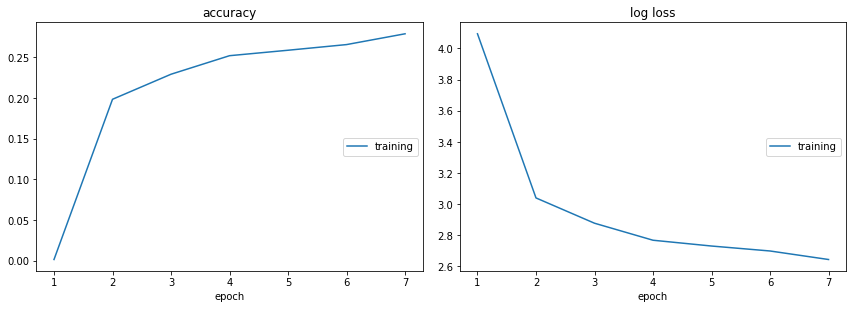

accuracy:
training   (min:    0.001, max:    0.279, cur:    0.279)

log loss:
training   (min:    2.644, max:    4.094, cur:    2.644)


In [ ]:
rock_lyrics_df.reset_index(drop=True, inplace=True)
acc= 0.0
loss = 0.0
size= 0.0
liveloss = PlotLosses()
preset_after= 100
for x in range(1000000):
    row = randomChoice(rock_lyrics_df)
    res = train_decoder(model, optimizer, row['ascii_lyrics'], criterion, x)
    if res is not None:
        sampele_acc, sample_loss, sample_size = res
        acc += sampele_acc
        loss += sample_loss
        size += sample_size
     
    if size > 0 and  x % preset_after == 0:
        liveloss.update({
          'log loss': loss/size,
          'accuracy': acc/size
          })
      
        liveloss.draw()  
        acc = 0.0        
        size = 0.0
        loss = 0.0


In [ ]:
def generate(model, start_chracter='T', max_length=20):
    with torch.no_grad():
        input = inputTensor1(start_letter)
        hidden = model.init_hidden()
        text = start_letter
        
        for i in range(max_length):
            input = input[0].reshape(1, 1, -1)
            model_output, hidden = model(input, hidden)
            _, topi = model_output.topk(1)
            topi = topi[0][0]
            if topi == n_characters - 1:
                break
            else:
                letter = all_characters[topi]
                text += letter
            input = inputTensor1(letter)        
    
    return text
    

In [ ]:
generate(model)

In [ ]:
generate(model, 'I')

In [ ]:
generate(model, 'W')

In [ ]:
generate(model, 'L')

### Final Tips
As a final tip, I do encourage you to do most of the work first on your local machine. They say that Data Scientists spend 80% of their time cleaning the data and preparing it for training (and 20% complaining about cleaning the data and preparing it). Handling these parts on your local machine usually mean you will spend less time complaining. You can switch to the cloud once your code runs and your pipeline is in place, for the actual training using a GPU.  

I also encourage you to use a small subset of the dataset first, so things run smoothly. The Metrolyrics dataset contains over 300k songs. You can start with a much much smaller set (even 3,000 songs) and try to train a network based on it. Once everything runs properly, add more data. 

Good luck!  
Omri